In [19]:
from train_dnn import get_data
import torch
from data import adult
from torch.utils.data import DataLoader
from dnn_models.model import MLP
from utils import load_model
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def load_data_and_model(model_id, use_protected_attr, protected_vars):
    dataset, train_loader, test_loader = get_data(adult, model_id, protected_vars)
    dataset.use_protected_attr = use_protected_attr
    all_X= dataset.get_all_data()

    in_dim = dataset.dim_feature()
    out_dim = 2

    model = MLP(in_dim, out_dim)
    load_model(model, 'MLP', 'adult', 'STDTrainer', use_protected_attr=use_protected_attr, \
               protected_vars=protected_vars, id=model_id, remark='epoch50')
    return model, dataset, all_X, train_loader, test_loader

def get_data_from_loader(loader):
    data = torch.Tensor()
    for batch in loader:
        data = torch.concat([data, batch[0]], dim=0)
    return data

def get_logits(model, X):
    if isinstance(X, torch.Tensor):
        return model(X)
    elif isinstance(X, DataLoader):
        logits = torch.Tensor()
        for batch in X:
            logits = torch.concat([logits, model(batch[0])], dim=0)
        return logits

In [20]:
model, dataset, all_X, train_loader, test_loader = load_data_and_model(0, True, ['sex_Male'])
train_data, test_data = get_data_from_loader(train_loader), get_data_from_loader(test_loader)
data_gen = adult.Adult_gen(sensitive_columns=['sex_Male'], include_protected_feature=True)
def data2feature(data):
    if isinstance(data, torch.Tensor):
        return data_gen._data2feature(data)
    elif isinstance(data, DataLoader):
        feature = torch.Tensor()
        for batch in data:
            feature = torch.concat([feature, data_gen._data2feature(batch[0])])
        return feature

In [21]:
p = lambda logits: torch.softmax(logits, dim=1).detach().numpy()
e = lambda p: -np.sum(p * np.log2(p), axis=1)

logits_train = model(train_data)
p_train = p(logits_train)
e_train = e(p_train)
feature_train = data2feature(train_loader)

logits_test = model(test_data)
p_test = p(logits_test)
e_test = e(p_test)
feature_test = data2feature(test_loader)

# logits_all = get_logits(model, all_X)
# p_all = torch.softmax(logits_all, dim=0)
# e_train = -torch.sum(p_train * torch.log2(p_train), dim=1)
feature_all = data2feature(all_X)

In [22]:
from sklearn.neighbors import KernelDensity

feature_range = torch.quantile(feature_train, torch.Tensor([0, 1]), dim=0)
def feature_norm(feature):
    l, u = feature_range[0], feature_range[1]
    return (feature - l)/(u - l)

data_range = torch.quantile(train_data, torch.Tensor([0, 1]), dim=0)
def data_norm(data):
    l, u = data_range[0], data_range[1]
    return (data - l)/(u - l)

# 假设X是已有样本的特征数据，X是一个N x D的矩阵，其中N是样本数量，D是特征维度
feature_kde = KernelDensity(bandwidth='silverman', kernel='gaussian')
feature_kde.fit(feature_norm(feature_train))

data_kde = KernelDensity(bandwidth='silverman', kernel='gaussian')
# data_kde.fit(train_data)
data_kde.fit(data_norm(train_data))

def log_density(data=None, feature=None, mode='feature'):
    if mode == 'feature':
        if feature == None and data != None:
            feature = data2feature(data).squeeze()
        feature = feature_norm(feature)
        return feature_kde.score_samples(feature.reshape(1, -1)).tolist()[0]
    else:
        if data == None: raise Exception()
        data = data_norm(data)
        return data_kde.score_samples(data.reshape(1, -1)).tolist()[0]

In [23]:
def box(data, label):
    assert len(data) == len(label)
    fig, ax = plt.subplots(figsize=(15, 2*len(data)))
    for i in range(len(data)):
        ax.boxplot(data[i], positions=[3*i], labels=[label[i]], vert=False)
        ax.violinplot(data[i], positions=[3*i+1], showmedians=True, quantiles=[0.25, 0.75], vert=False)
    ax.xaxis.grid(True)
    ax.set_yticks([3*i+0.5 for i in range(len(data))], labels=label)

In [24]:
def marginal_data(data, model):
    prediction = model.get_prediction(data)
    counterfactual_data_sex = data.clone()
    counterfactual_data_race = data.clone()
    counterfactual_data_sex[33] = 1-counterfactual_data_sex[33]
    counterfactual_data_race[26] = 1-counterfactual_data_race[26]
    cf_sex_prediction = model.get_prediction(counterfactual_data_sex)
    cf_race_prediction = model.get_prediction(counterfactual_data_race)
    unfair_index_sex = torch.where(cf_sex_prediction != prediction)[0]
    unfair_index_race = torch.where(cf_race_prediction != prediction)[0]

    return data[unfair_index_sex], data[unfair_index_race]

train_sex_unfair_data, train_race_unfair_data = marginal_data(train_data, model)
test_sex_unfair_data, test_race_unfair_data = marginal_data(test_data, model)

In [25]:
def get_log_pairs(log_path):
    with open(os.path.join('log', f'{log_path}.log'),'r') as f:
        lines = f.readlines()
        pairs = torch.Tensor()
        for line in lines[1:]:
            t, s, n, p = line.split('\t')
            p = torch.tensor(eval(p))
            pairs = torch.concat([pairs, p], dim=0)
        return torch.Tensor(pairs)

In [26]:
weird_data = get_log_pairs('eu_black')

In [27]:
train_feature = data2feature(train_loader)
train_density = []
# for i in tqdm(range(train_feature.shape[0])):
#     train_density.append(log_density(feature=train_feature[i]))
for i in tqdm(range(train_data.shape[0])):
    train_density.append(log_density(data=train_data[i], mode='data'))
train_density = np.log(-np.array(train_density))

100%|██████████| 36177/36177 [07:29<00:00, 80.43it/s] 


In [28]:
test_feature = data2feature(test_loader)
test_density = []
# for i in tqdm(range(test_feature.shape[0])):
#     test_density.append(log_density(feature=test_feature[i]))
for i in tqdm(range(test_data.shape[0])):
    test_density.append(log_density(data=test_data[i], mode='data'))
test_density = np.log(-np.array(test_density))

100%|██████████| 9045/9045 [01:45<00:00, 85.72it/s] 


In [29]:
weird_density = []
# for i in tqdm(range(len(weird_data))):
#     weird_density.append(log_density(data=weird_data[i]))
for i in tqdm(range(weird_data.shape[0])):
    weird_density.append(log_density(data=weird_data[i], mode='data'))
weird_density = np.log(-np.array(weird_density))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:25<00:00, 77.10it/s] 


In [30]:
distri_data = get_log_pairs('eu_distribution')
distribution_density = []
# for i in tqdm(range(len(distri_data))):
#     distribution_density.append(log_density(data=distri_data[i]))
for i in tqdm(range(distri_data.shape[0])):
    distribution_density.append(log_density(data=distri_data[i], mode='data'))
distribution_density = np.log(-np.array(distribution_density))

100%|██████████| 2000/2000 [00:25<00:00, 77.60it/s] 


In [31]:
range_data = get_log_pairs('eu_range')
range_density = []
# for i in tqdm(range(len(range_data))):
#     range_density.append(log_density(data=range_data[i]))
for i in tqdm(range(range_data.shape[0])):
    range_density.append(log_density(data=range_data[i], mode='data'))
range_density = np.log(-np.array(range_density))

100%|██████████| 2000/2000 [00:25<00:00, 78.25it/s] 


使用训练集数据进行核密度估计
下图是各个数据集合的样本似然分布
数值越大代表概率越低（log(-log(likelyhood))

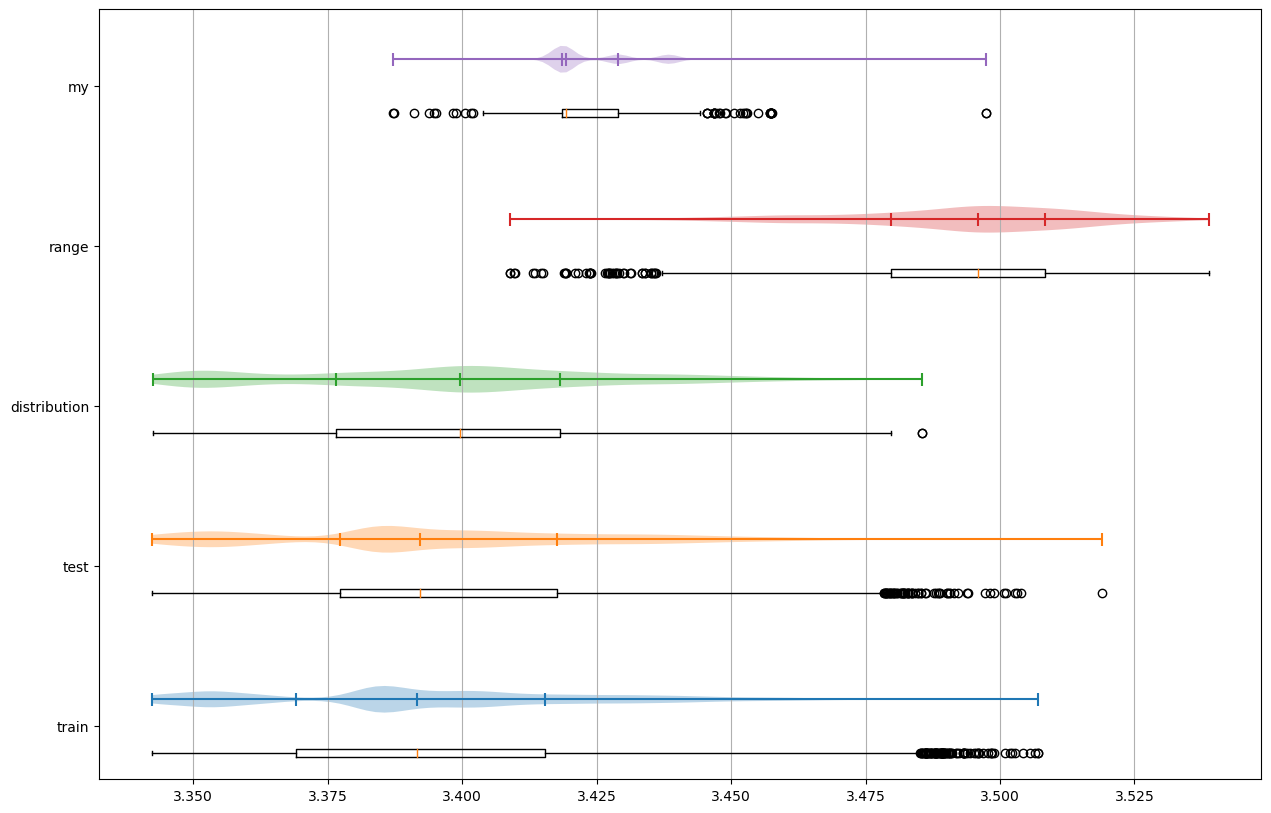

In [32]:
box(data=[train_density, test_density, distribution_density, range_density, weird_density],\
     label=['train', 'test', 'distribution', 'range', 'my'])

In [37]:
show_data(weird_data)

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,90.0,10129.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
1,90.0,9484.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
2,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
3,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
4,90.0,12114.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
5,90.0,8889.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
6,90.0,9633.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
7,90.0,9504.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
8,17.0,2005.0,189.0,6.0,6.0,0.0,0.0,2.0,3.0,0.0,3.0
9,17.0,2005.0,189.0,2.0,1.0,0.0,0.0,2.0,3.0,0.0,3.0


KeyboardInterrupt: Interrupted by user

In [33]:
data_origin = train_data

data_filtered = data_origin[
    torch.logical_and(data_origin[:, 0]>=70, data_origin[:, 4]>=70)
]

for i in range(len(data_filtered)):
    print(np.log(-log_density(data=data_filtered[i], mode='data')))

3.47117544248115
3.4032373885911955
3.3929920858055294
3.3918876535634244
3.3697651752193174
3.442266593422069
3.36049732545868
3.3925361103066587
3.464299466643552
3.3969308165058
3.4648704473195746
3.4110458930806944
3.461428252375017
3.358361848144437
3.4745470143929884


In [34]:
import math
from IPython.display import clear_output
def show_data(data):
    data_len = data.shape[0]
    for i in range(math.ceil(data_len/20)):
        l = 20*i
        r = min(20*(i + 1), data_len)
        display(adult.get_original_feature(data[l : r]))
        input()
        clear_output(())

不筛选

In [35]:
logits_weird = get_logits(model, weird_data)
p_weird = p(logits_weird)
e_weird = e(p_weird)

logits_range = get_logits(model, range_data)
p_range = p(logits_range)
e_range = e(p_range)

logits_distribution = get_logits(model, distri_data)
p_distribution = p(logits_distribution)
e_distributin = e(p_distribution)

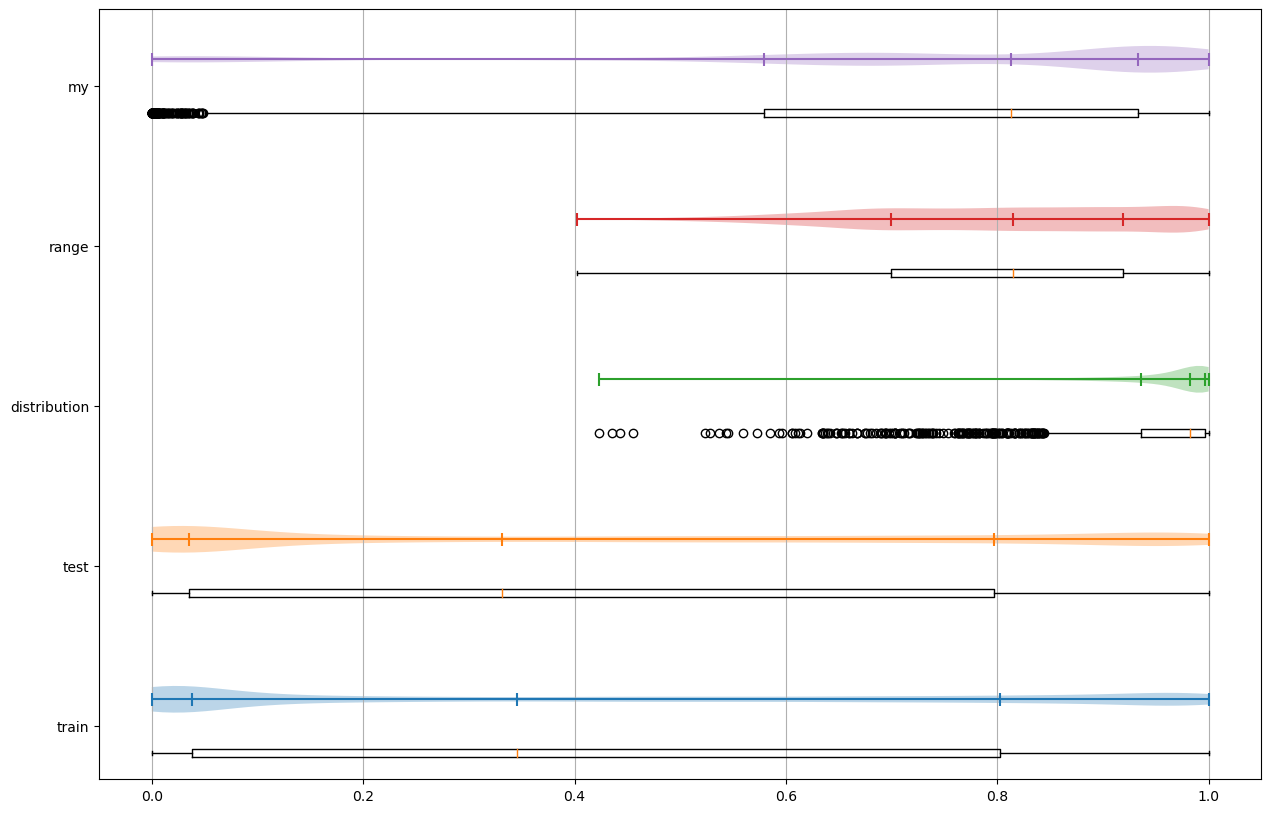

In [36]:
box(data=[e_train, e_test, e_distributin, e_range, e_weird], \
    label=['train', 'test', 'distribution', 'range', 'my'])

1. 验证真实样本中熵较大的是不是异常样本
2. 验证真实不公平的样本是不是异常样本，以及真实不公平样本相对于构造不公平样本的真实性有什么不同？

确认一下为什么训练集和测试集集中在两段

训练集测试集熵大的是不是也是异常的样本（概率密度小）


画、确定思路

按照似然概率密度筛选

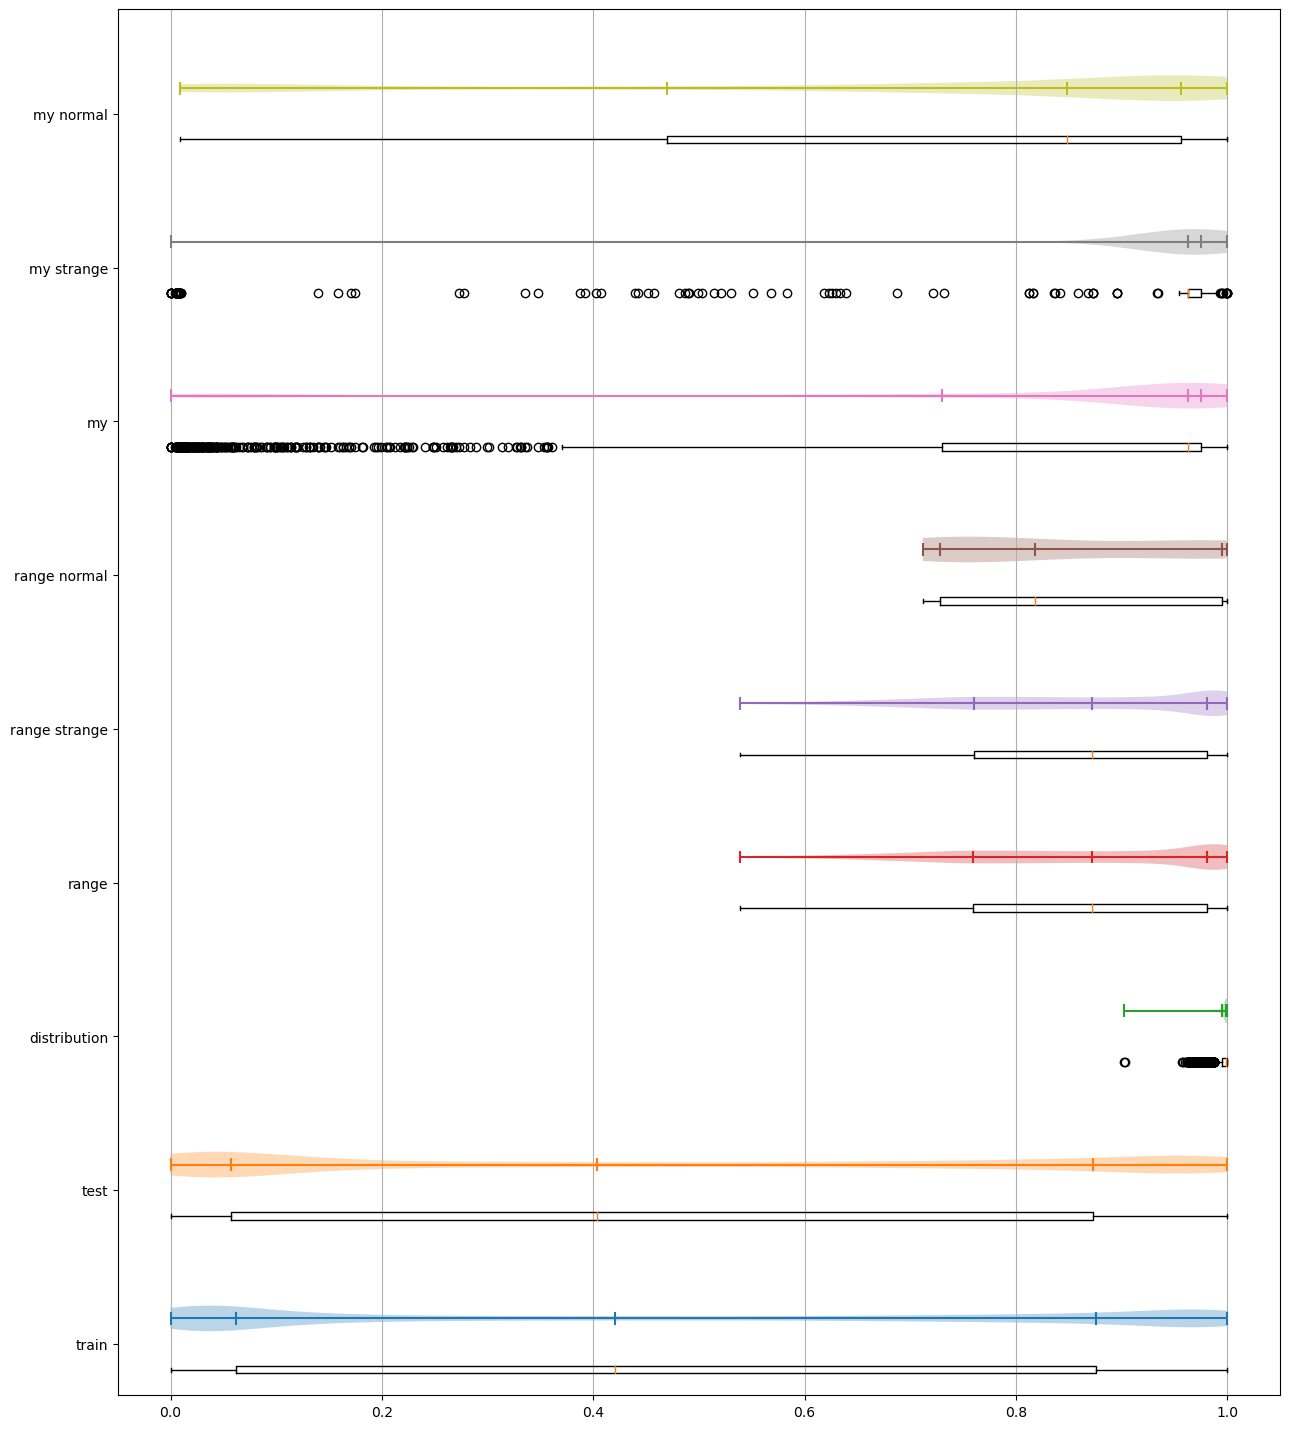

In [19]:
th = 3.42

weird_data_fd = weird_data[weird_density>=th]
range_data_fd = range_data[range_density>=th]

weird_data_out = weird_data[weird_density<th]
range_data_out = range_data[range_density<th]

logits_weird_fd = get_logits(model, weird_data_fd)
p_weird_fd = p(logits_weird_fd)
e_weird_fd = e(p_weird_fd)

logits_range_fd = get_logits(model, range_data_fd)
p_range_fd = p(logits_range_fd)
e_range_fd = e(p_range_fd)

logits_weird_out = get_logits(model, weird_data_out)
p_weird_out = p(logits_weird_out)
e_weird_out = e(p_weird_out)

logits_range_out = get_logits(model, range_data_out)
p_range_out = p(logits_range_out)
e_range_out = e(p_range_out)

box(data=[e_train, e_test, e_distributin, e_range, e_range_fd, e_range_out, e_weird, e_weird_fd, e_weird_out], \
    label=['train', 'test', 'distribution', 'range', 'range strange', 'range normal', 'my', 'my strange', 'my normal'])

In [ ]:
# weird_data_t = weird_data[weird_density<5]
# show_data(weird_data_t)

人工判断筛选

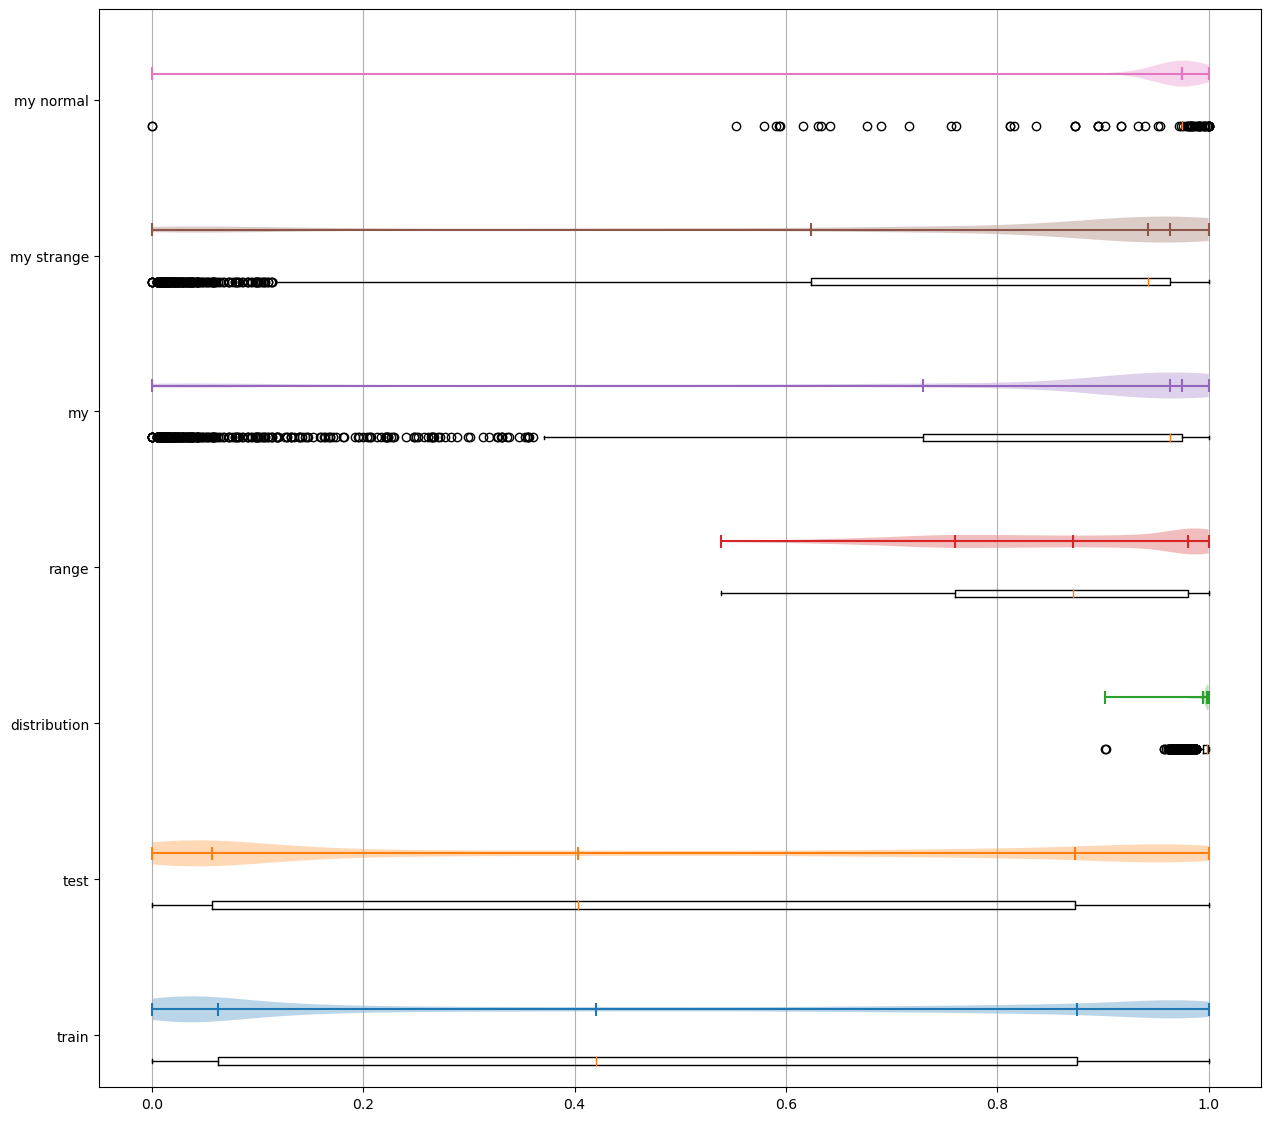

In [20]:
weird_data_fh = weird_data[
    torch.logical_and(weird_data[:, 0]>=70, weird_data[:, 4]>=70)
]

weird_data_fh2 = weird_data[
    torch.logical_or(weird_data[:, 0]<70, weird_data[:, 4]<70)
]

logits_weird_fh = get_logits(model, weird_data_fh)
p_weird_fh = p(logits_weird_fh)
e_weird_fh = e(p_weird_fh)

logits_weird_fh2 = get_logits(model, weird_data_fh2)
p_weird_fh2 = p(logits_weird_fh2)
e_weird_fh2 = e(p_weird_fh2)

box(data=[e_train, e_test, e_distributin, e_range, e_weird, e_weird_fh, e_weird_fh2], \
    label=['train', 'test', 'distribution', 'range', 'my', 'my strange', 'my normal'])

数据中是不是真的有奇怪样本
高斯核的估计方法 norm
异常值大的熵有什么表现

In [38]:
data_origin = weird_data

data_filtered = data_origin[
    torch.logical_and(data_origin[:, 0]>=70, data_origin[:, 4]>=70)
]

# data_filtered = data_origin[
#     e_train > 0.85
# ]

print(f'number of filtered samples: {len(data_filtered)}')
show_data(data_filtered)

number of filtered samples: 1561


,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
1,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
2,90.0,12479.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
3,90.0,9249.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
4,90.0,10467.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
5,90.0,7237.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
6,90.0,5900.0,1492.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
7,90.0,5618.0,165.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
8,90.0,12286.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
9,90.0,9062.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0


KeyboardInterrupt: Interrupted by user